In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


In [ ]:
df = pd.read_excel("C:\Users\Gauransh Singh\Desktop\EmployeeSentimentAnalysis\data\test.xlsx")
df.head()


,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com


In [ ]:

df.dropna(subset=['body'], inplace=True)


df['date'] = pd.to_datetime(df['date'], errors='coerce')


df['month'] = df['date'].dt.to_period('M')

df.head()


,Subject,body,date,from,month
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com,2010-05
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com,2010-07
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com,2011-07
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com,2010-03
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com,2011-05


In [ ]:
def get_sentiment(text):
    score = TextBlob(str(text)).sentiment.polarity
    if score > 0.1:
        return 'Positive'
    elif score < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['body'].apply(get_sentiment)
df[['body', 'sentiment']].head()


,body,sentiment
0,EnronOptions Announcement\n\n\nWe have updated...,Positive
1,"Marc,\n\nUnfortunately, today is not going to ...",Neutral
2,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",Neutral
3,we were thinking papasitos (we can meet somewh...,Negative
4,Since you never gave me the $20 for the last t...,Neutral


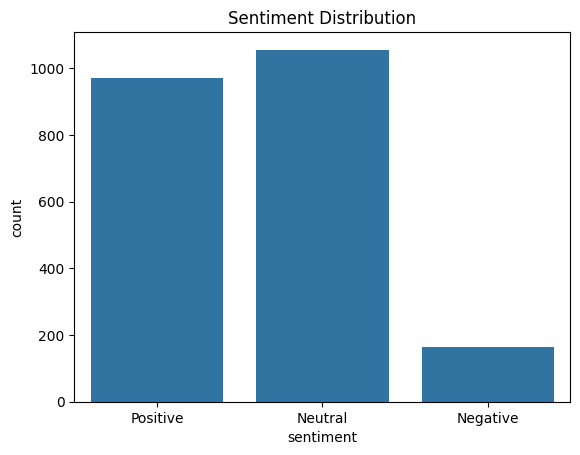

In [ ]:
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.show()


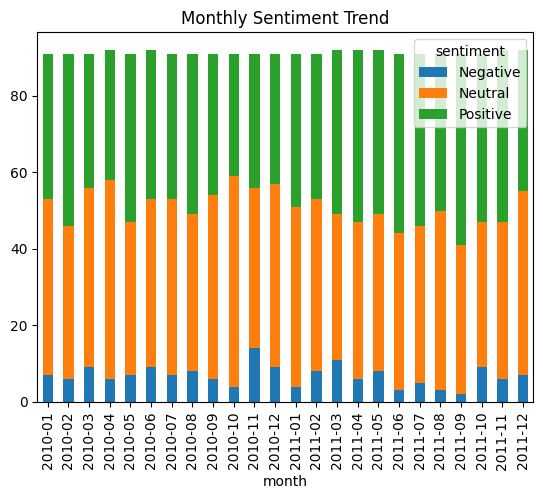

In [ ]:
monthly = df.groupby(['month', 'sentiment']).size().unstack().fillna(0)
monthly.plot(kind='bar', stacked=True)
plt.title("Monthly Sentiment Trend")
plt.show()


In [ ]:
score_map = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
df['score'] = df['sentiment'].map(score_map)


In [ ]:
monthly_score = df.groupby(['from', 'month'])['score'].sum().reset_index()
monthly_score.head()


,from,month,score
0,bobette.riner@ipgdirect.com,2010-01,2
1,bobette.riner@ipgdirect.com,2010-02,7
2,bobette.riner@ipgdirect.com,2010-03,4
3,bobette.riner@ipgdirect.com,2010-04,2
4,bobette.riner@ipgdirect.com,2010-05,1


In [ ]:
for month in monthly_score['month'].unique():
    data = monthly_score[monthly_score['month'] == month]
    top3 = data.nlargest(3, 'score')
    bottom3 = data.nsmallest(3, 'score')
    
    print(f"\nMonth: {month}")
    print("Top 3 Positive Employees:\n", top3)
    print("Top 3 Negative Employees:\n", bottom3)



Month: 2010-01
Top 3 Positive Employees:
                          from    month  score
120   kayne.coulter@enron.com  2010-01      5
168  patti.thompson@enron.com  2010-01      5
24     don.baughman@enron.com  2010-01      4
Top 3 Negative Employees:
                             from    month  score
192      rhonda.denton@enron.com  2010-01      0
96       johnny.palmer@enron.com  2010-01      1
0    bobette.riner@ipgdirect.com  2010-01      2

Month: 2010-02
Top 3 Positive Employees:
                            from    month  score
1   bobette.riner@ipgdirect.com  2010-02      7
73        john.arnold@enron.com  2010-02      7
25       don.baughman@enron.com  2010-02      6
Top 3 Negative Employees:
                          from    month  score
145   lydia.delgado@enron.com  2010-02      1
169  patti.thompson@enron.com  2010-02      1
217      sally.beck@enron.com  2010-02      1

Month: 2010-03
Top 3 Positive Employees:
                             from    month  score
218         

In [ ]:
negatives = df[df['sentiment'] == 'Negative']
flight_risk = negatives.groupby(['from', 'month']).size().reset_index(name='negative_count')
flight_risk = flight_risk[flight_risk['negative_count'] >= 4]
flight_risk


,from,month,negative_count
5,bobette.riner@ipgdirect.com,2010-11,5
73,lydia.delgado@enron.com,2011-12,4


In [ ]:
df['msg_length'] = df['body'].apply(lambda x: len(str(x).split()))

features = df.groupby('from').agg({
    'msg_length': 'mean',
    'score': 'sum'
}).reset_index()

X = features[['msg_length']]
y = features['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
import numpy as np

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("R2 Score:", r2)
print("RMSE:", rmse)


R2 Score: -0.681256696986797
RMSE: 17.504543211002215


In [ ]:
df['word_count'] = df['body'].apply(lambda x: len(str(x).split()))
df['avg_word_length'] = df['body'].apply(lambda x: np.mean([len(w) for w in str(x).split()]) if len(str(x).split()) > 0 else 0)
df['pos_flag'] = df['sentiment'].apply(lambda x: 1 if x == 'Positive' else 0)


In [15]:
features = df.groupby('from').agg({
    'msg_length': 'mean',
    'word_count': 'mean',
    'avg_word_length': 'mean',
    'score': 'sum'
}).reset_index()

X = features[['msg_length', 'word_count', 'avg_word_length']]
y = features['score']


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("R2 Score:", r2)
print("RMSE:", rmse)


R2 Score: -1.4286525904163017
RMSE: 21.038582048307603


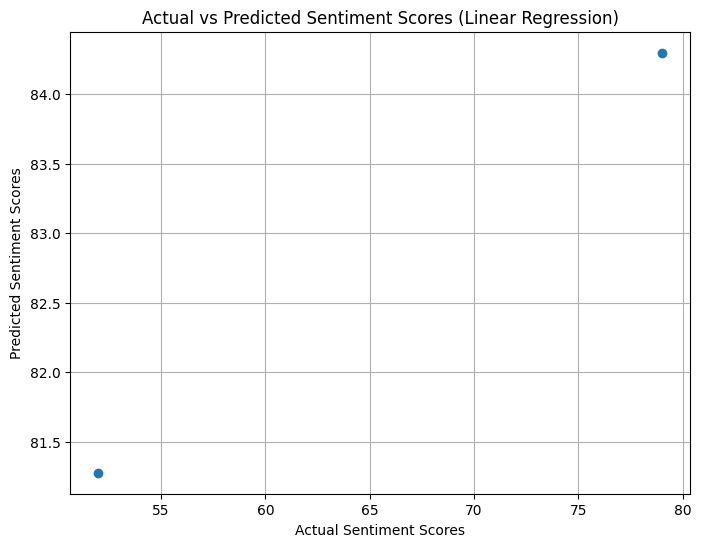

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Sentiment Scores")
plt.ylabel("Predicted Sentiment Scores")
plt.title("Actual vs Predicted Sentiment Scores (Linear Regression)")
plt.grid(True)

plt.savefig('../visualizations/actual_vs_predicted.png')

plt.show()
